In [1]:
Create_Dataset_folders = 0
Retrain_Model = 1
first_run = 1

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
from distutils.filelist import FileList
import pprint

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

In [5]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [6]:
import os
import shutil
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [7]:
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/5th_Year_Project/Eight_Iteration_CNN_Live_Large/'


In [8]:
dataset =BASE_PATH + 'LargeDataset.zip'
error_folder = BASE_PATH + 'LargeDataset_Error.zip'
print(dataset)
#/content/drive/MyDrive/Colab Notebooks/5th_Year_Project/Eight_Iteration_CNN_Live/v5Dataset.zip

/content/drive/MyDrive/Colab Notebooks/5th_Year_Project/Eight_Iteration_CNN_Live_Large/LargeDataset.zip


In [9]:

batch_size = 32
num_classes = 6

In [10]:
import numpy as np

def gaussian_mutation(individual, mutation_rate, scale=0.1):
    """
    Performs Gaussian mutation on an individual.
    """
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            old_shape = individual[i].shape
            individual[i] += np.random.normal(scale=scale, size=individual[i].shape)
            if individual[i].shape != old_shape:
                individual[i] = np.resize(individual[i], old_shape)
    return individual


def uniform_mutation(individual, mutation_rate, scale=0.1):
    """
    Performs uniform mutation on an individual.
    """
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            old_shape = individual[i].shape
            individual[i] += np.random.uniform(-scale, scale, size=individual[i].shape)
            if individual[i].shape != old_shape:
                individual[i] = np.resize(individual[i], old_shape)
    return individual


def permutation_mutation(individual, mutation_rate, scale=0.1):
    """
    Performs permutation mutation on an individual.
    """
    if np.random.rand() < mutation_rate:
        indices = np.random.choice(len(individual), size=2, replace=False)
        old_shape_1 = individual[indices[0]].shape
        old_shape_2 = individual[indices[1]].shape
        individual[indices[0]], individual[indices[1]] = individual[indices[1]], individual[indices[0]]
        if individual[indices[0]].shape != old_shape_1:
            individual[indices[0]] = np.resize(individual[indices[0]], old_shape_1)
        if individual[indices[1]].shape != old_shape_2:
            individual[indices[1]] = np.resize(individual[indices[1]], old_shape_2)
    return individual



def create_population(n, model, mutation_rate, scale=0.1):
    """
    Creates a population of n individuals, each with random mutations based on the weights of the given model.
    """
    population = []
    for i in range(n):
        individual = mutate(model.get_weights(), mutation_rate, scale)
        population.append(individual)
    return population


def compute_fitness(model, population, train_dataset, valid_dataset):
    """
    Computes the fitness of each individual in the population using the validation accuracy
    of the model on the given datasets.
    """
    fitness_values = [model.evaluate(valid_dataset, verbose=0)[1] for individual in population]
    return fitness_values


def select_parents(population, fitness_values):
    """
    Selects two parents from the population using fitness-proportional selection.
    """
    total_fitness = sum(fitness_values)
    probabilities = [fitness / total_fitness for fitness in fitness_values]
    parent1_index = np.random.choice(len(population), p=probabilities)
    parent2_index = np.random.choice(len(population), p=probabilities)
    return population[parent1_index], population[parent2_index]


def crossover(parent1, parent2):
    """
    Performs a simple crossover operation between two parents.
    """
    child = np.zeros_like(parent1)
    child = np.where(np.random.rand(len(parent1)) < 0.5, parent1, parent2)
    return child


def mutate(individual, mutation_rate, scale=0.1):
    """
    Performs a random mutation on an individual.
    The mutation can be one of three types: adding random noise, flipping signs, or swapping values.
    """
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            mutation_type = np.random.choice(['noise', 'flip', 'swap', 'gauss', 'uniform', 'permute'])
            if mutation_type == 'noise':
                individual[i] += np.random.randn() * scale
            elif mutation_type == 'flip':
                individual[i] *= -1
            elif mutation_type == 'swap':
                j = np.random.randint(len(individual))
                individual[i], individual[j] = individual[j], individual[i]
            elif mutation_type == 'gauss':
              individual =  gaussian_mutation(individual, mutation_rate, scale)
            elif mutation_type == 'uniform':
              individual =  uniform_mutation(individual, mutation_rate, scale)
            elif mutation_type == 'permute':
              individual =  permutation_mutation(individual, mutation_rate, scale)            
    return individual


def genetic_algorithm(model, train_dataset, valid_dataset, population_size=200, num_generations=5,
                      mutation_rate=0.7, scale=0.5):
    """
    Runs a genetic algorithm to optimize the weights of the model on the given datasets.
    """
    num_weights = len(model.get_weights())
    population = create_population(population_size, model, mutation_rate, scale)
    best_individual = model.get_weights()
    best_fitness = model.evaluate(valid_dataset)[1]
    print('Begin Genetics')
    for i in range(num_generations):
        fitness_values = compute_fitness(model, population, train_dataset, valid_dataset)
        new_population = []
        print('New Population')
        for j in range(population_size):
            parent1, parent2 = select_parents(population, fitness_values)
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate, scale)
            new_population.append(child)
        if max(fitness_values) > best_fitness:
            best_individual = population[np.argmax(fitness_values)]
            best_fitness = max(fitness_values)
        print("Generation:", i+1, "Best Fitness:", best_fitness)
    model.set_weights(best_individual)
    print('Best Individual Found')
    return model



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 149, 16)      304       
                                                                 
 batch_normalization (BatchN  (None, 148, 149, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 148, 32)      3104      
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 146, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 144, 146, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 72, 73, 64)       0

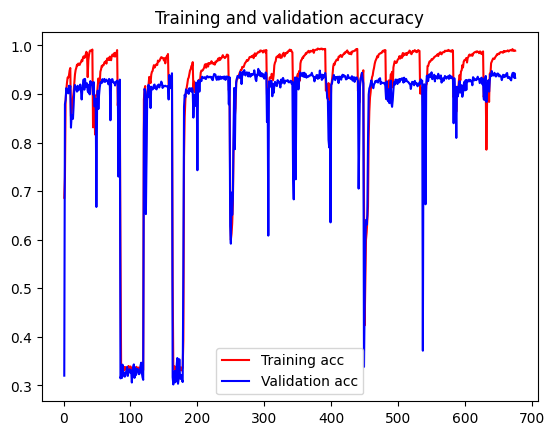

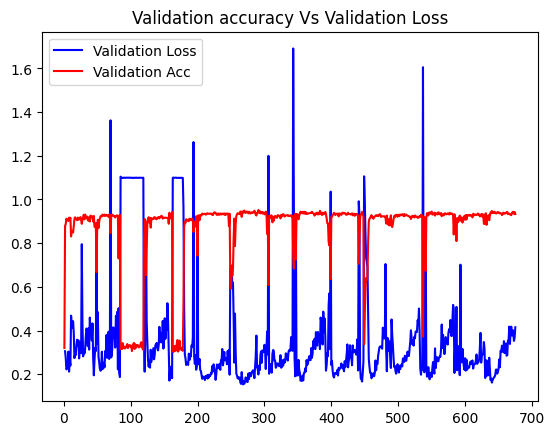

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam

data_folder = dataset
datasets = []

# Set mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

import zipfile

# Extract the zip file
with zipfile.ZipFile(data_folder, 'r') as zip_ref:
    zip_ref.extractall()

data_folder ='/content/LargeDataset/'


datasets = []
for folder_name in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder_name)
    if os.path.isdir(folder_path):
        datasets.append(folder_path)

# Extract the zip file
with zipfile.ZipFile(error_folder, 'r') as zip_ref:
    zip_ref.extractall()

error_folder ='/content/LargeDataset_Error/'

Error_datasets = []
for folder_name in os.listdir(error_folder):
    folder_path = os.path.join(error_folder, folder_name)
    if os.path.isdir(folder_path):
        Error_datasets.append(folder_path)



# Set batch size and number of epochs
batch_size = 32
epochs = 100

# Define the CNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 2), activation="relu", input_shape=(150, 150, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 2), activation="relu"),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5, seed=2023),
    tf.keras.layers.Dense(128, activation="relu"),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25, seed=2023),
    tf.keras.layers.Dense(3, activation="softmax")
])


# define the checkpoint
checkpoint_filepath = 'best_weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)



model.build()

learning_rate=0.005

# Compile the model with mixed precision
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['acc'])

model.summary()

# Train the model on multiple datasets
histories = []
best_weights = None
best_val_acc = 0

# Separate iteration variables for datasets and error folders
k = 0  # dataset counter
j = 0  # error folder counter

# Loop through all datasets and error folders in the desired order
for i in range(15):
  print(f"Training on dataset {i}/15...")
  if i % 2 == 0:  # even iteration number, use a dataset
    print(f"Dataset {k}")
    dataset = datasets[k]
    train_steps = 10000 // batch_size
    val_steps = 2000 // batch_size
    test_steps = 1000 // batch_size
    k += 1  # increment dataset counter
    
  else:  # odd iteration number, use an error folder
    print(f"Dataset {j}")
    dataset = Error_datasets[j]
    train_steps = 3000 // batch_size
    val_steps = 2000 // batch_size
    test_steps = 750 // batch_size
    j += 1  # increment error folder counter
        
 # Get the train, test, and validation directories for this dataset
  train_dir = os.path.join(dataset, 'train')
  print(train_dir)
  test_dir = os.path.join(dataset, 'test')
  print(test_dir)
  valid_dir = os.path.join(dataset, 'valid')
  print(valid_dir)

  train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255,
      # rotation_range=20,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      # zoom_range=0.2,
      # horizontal_flip=True,
      # fill_mode='nearest'
  )
  train_dataset = train_generator.flow_from_directory(
      train_dir,
      target_size=(150, 150),
      batch_size=batch_size,
      class_mode='categorical'
  )

  valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255
  )
  valid_dataset = valid_generator.flow_from_directory(
      valid_dir,
      target_size=(150, 150),
      batch_size=batch_size,
      class_mode='categorical'
  )
  test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255
  )
  test_dataset = test_generator.flow_from_directory(
      test_dir,
      target_size=(150, 150),
      batch_size=batch_size,
      class_mode='categorical'
  )

  # if i == 0:
  #   learning_rate = 0.01
  # elif i ==2:
  #   learning_rate = 0.001 
  # elif i ==6:
  #   learning_rate = 0.0001
  # elif i ==8:
  #   learning_rate = 0.00001
  # elif i ==12:
  #   learning_rate = 0.001
  
  def lr_schedule(epoch, lr):

    if epoch <=10:
        return 0.005
    elif epoch > 10:
        return 0.001
    elif epoch > 20:
        return 0.0005
    elif epoch > 30:
        return 0.0001
    elif epoch > 40:
        return 0.00005
    elif epoch > 50:
        return 0.00001

  from keras.callbacks import ModelCheckpoint

  optimizer=Adam(learning_rate)
  # Compile the model
  model.compile(optimizer,
                loss='categorical_crossentropy',
                metrics=['acc'])
  
  # # # Apply genetic algorithm between each dataset
  # if i > 0:
  #     model = genetic_algorithm(model, previous_valid_dataset, valid_dataset)
      
  # previous_valid_dataset = valid_dataset;


  # Define early stopping criteria
  early_stop = EarlyStopping(monitor='val_loss', patience=35)




  # Train the model
  history = model.fit(train_dataset,
                      epochs=epochs,
                      steps_per_epoch=train_steps,
                      validation_data=valid_dataset,
                      validation_steps=val_steps,
                      callbacks=[LearningRateScheduler(lr_schedule), model_checkpoint_callback, early_stop])
  
  histories.append(history.history)

  #Load the best weights
  model.load_weights(checkpoint_filepath)



# Concatenate the histories
acc = np.concatenate([history["acc"] for history in histories])
val_acc = np.concatenate([history["val_acc"] for history in histories])
loss = np.concatenate([history["loss"] for history in histories])
val_loss = np.concatenate([history["val_loss"] for history in histories])
epochs = range(1, len(acc) + 1)

# Plot the evaluation results
plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Validation accuracy Vs Validation Loss")
plt.legend()
plt.show()

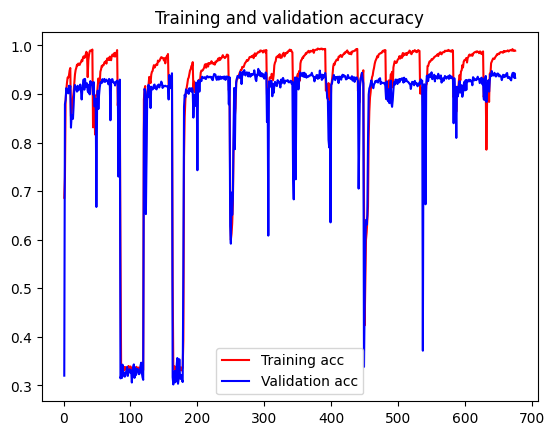

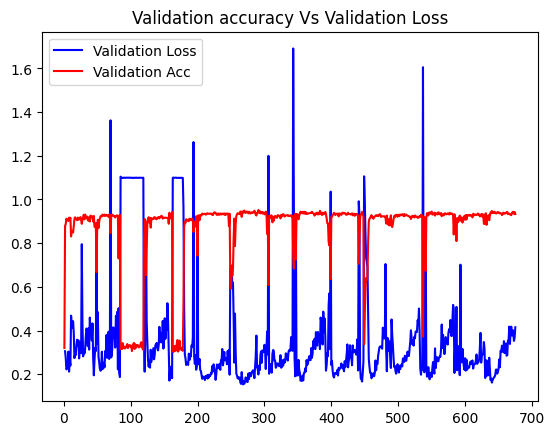

In [ ]:
#Load the best weights
model.load_weights(checkpoint_filepath)

# Concatenate the histories
acc = np.concatenate([history["acc"] for history in histories])
val_acc = np.concatenate([history["val_acc"] for history in histories])
loss = np.concatenate([history["loss"] for history in histories])
val_loss = np.concatenate([history["val_loss"] for history in histories])
epochs = range(1, len(acc) + 1)

# Plot the evaluation results
plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Validation accuracy Vs Validation Loss")
plt.legend()
plt.show()

In [ ]:
if Retrain_Model: 
  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 149, 16)      304       
                                                                 
 batch_normalization (BatchN  (None, 148, 149, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 148, 32)      3104      
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 146, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 144, 146, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 72, 73, 64)       0

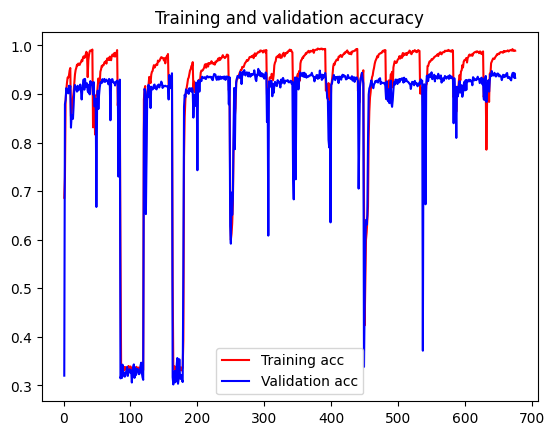

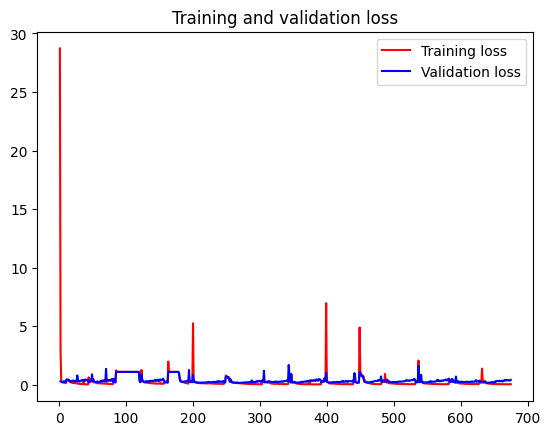

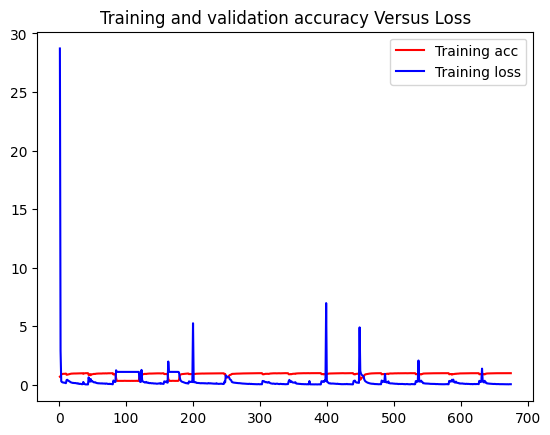

In [ ]:
if Retrain_Model:   
  # Plot the evaluation results

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.title('Training and validation accuracy Versus Loss')
  plt.legend()
  plt.show()

94/94 [==============================] - 3s 27ms/step


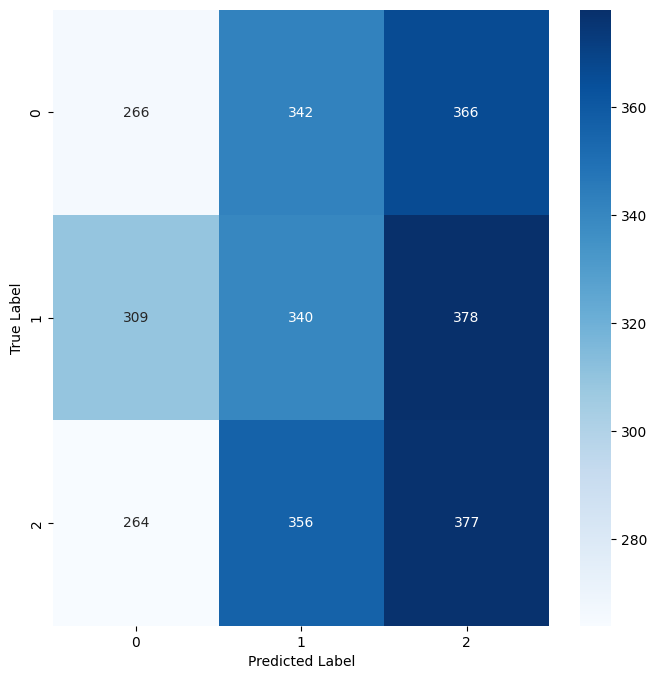

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the validation set
y_pred = model.predict(valid_dataset)

# Convert the predictions from one-hot encoded to class labels
y_pred = np.argmax(y_pred, axis=1)

# Get the true class labels
y_true = valid_dataset.classes

# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
keras_model_path = BASE_PATH + "keras_saved_model"
model.save(keras_model_path)

In [ ]:
restored_keras_model = tf.keras.models.load_model(keras_model_path)

In [ ]:
# Load the trained model
model = restored_keras_model

# Evaluate the model
eval_loss, eval_acc = model.evaluate(valid_dataset)
print("Evaluation loss: ", eval_loss)
print("Evaluation accuracy: ", eval_acc)

94/94 [==============================] - 3s 26ms/step - loss: 0.1748 - acc: 0.9356
Evaluation loss:  0.17478832602500916
Evaluation accuracy:  0.9356237649917603


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels and predicted labels on the validation set
Y_val = []
Y_pred = []
for i in range(len(valid_dataset)):
    x_val, y_val = valid_dataset[i]
    Y_val.extend(np.argmax(y_val, axis=1))
    Y_pred.extend(np.argmax(model.predict(x_val), axis=1))

# Generate a classification report and confusion matrix
print('Classification Report')
print(classification_report(Y_val, Y_pred))
print('Confusion Matrix')
cm = confusion_matrix(Y_val, Y_pred)
print(cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=14, color='black')
ax.set_ylabel('True labels', fontsize=14, color='black')
ax.set_xticks(range(len(valid_dataset.class_indices)))
ax.set_xticklabels(valid_dataset.class_indices.keys(), fontsize=12, rotation=45)
ax.set_yticks(range(len(valid_dataset.class_indices)))
ax.set_yticklabels(valid_dataset.class_indices.keys(), fontsize=12)
for i in range(len(valid_dataset.class_indices)):
    for j in range(len(valid_dataset.class_indices)):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=14)
plt.show()


plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training accuracy versus loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels and predicted labels on the validation set
Y_val = []
Y_pred = []
for i in range(len(test_dataset)):
    x_val, y_val = test_dataset[i]
    Y_val.extend(np.argmax(y_val, axis=1))
    Y_pred.extend(np.argmax(model.predict(x_val), axis=1))

# Generate a classification report and confusion matrix
print('Classification Report')
print(classification_report(Y_val, Y_pred))
print('Confusion Matrix')
cm = confusion_matrix(Y_val, Y_pred)
print(cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=14, color='black')
ax.set_ylabel('True labels', fontsize=14, color='black')
ax.set_xticks(range(len(test_dataset.class_indices)))
ax.set_xticklabels(test_dataset.class_indices.keys(), fontsize=12, rotation=45)
ax.set_yticks(range(len(test_dataset.class_indices)))
ax.set_yticklabels(test_dataset.class_indices.keys(), fontsize=12)
for i in range(len(test_dataset.class_indices)):
    for j in range(len(test_dataset.class_indices)):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=14)
plt.show()

# Plot the accuracy and loss curves for training and validation sets

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='testing acc')
plt.title('Training and testing accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='testing loss')
plt.title('Training and testing loss')
plt.legend()
plt.show()

plt.plot(epochs, val_acc, 'r', label='Training acc')
plt.plot(epochs, val_loss, 'b', label='Training loss')
plt.title('Training accuracy versus loss')
plt.legend()
plt.show()